# Image Classification using Gradient Boosting

#### 3.1 Resize, and convert all the images to array within the training folder

In [17]:
import os
from PIL import Image
import numpy as np
import warnings
from joblib import dump, load
warnings.filterwarnings("ignore")

def get_image_paths(folder_path):
    image_extensions = [".jpg", ".jpeg", ".png"]
    image_paths = []
    for filename in os.listdir(folder_path):
        if any(ext in filename.lower() for ext in image_extensions):
            image_paths.append(os.path.join(folder_path, filename))
    return image_paths

data_folder = "Training_Data"
subfolders = ["1-San", "2-Ge", "2-Ge_fanti", "3-Chou", "4-Pi", "5-Jiang"]
image_rgb = []

# Initialize X_train and y_train
X_train = []
y_train = []

for subfolder in subfolders:
    subfolder_path = os.path.join(data_folder, subfolder)
    image_paths = get_image_paths(subfolder_path)
    
    for image_path in image_paths:
        image = Image.open(image_path).convert("P")
        image = image.resize((400, 514))  # Resize the image, following ICA requirement
        image_rgb.append(image.convert("RGB"))
        
        image_array = np.array(image) # convert the image in P mode to numpy array
        
        X_train.append(image_array)
        y_train.append(subfolder)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (309, 514, 400)
y_train shape: (309,)


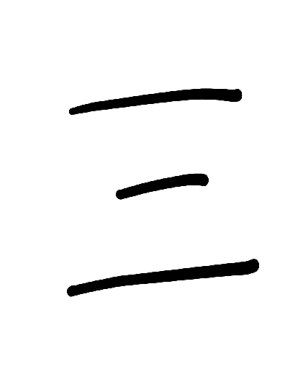

In [18]:
# Test data
import matplotlib.pyplot as plt
plt.imshow(image_rgb[0])
plt.axis('off')
plt.show()

#### 3.2 Prepare the test data for making predictions

In this section, the same concept of converting all the "unseen" data to an array of 514 x 400 pixels. The images have been arranged in such a way:

(5 x 'unseen' images per word)
1. 1-San
2. 2-Ge
3. 2-Ge_fanti
4. 3-Chou
5. 4-Pi
6. 5-Jiang

This is for the ease of gauging the model's performance as at a glance, as a dataframe will be used to store the results in the later part.


In [19]:
# Convert the test images into an array

# Directory path containing the images
directory = "./New_Data"

# List to store the image arrays
image_arrays = []
image_arrays_rgb = []

# Iterate over the files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        # Construct the image path
        image_path = os.path.join(directory, filename)

        # Open, convert, and resize the image
        image = Image.open(image_path).convert("P").resize((400, 514))

        # Convert the image to an array
        image_array = np.array(image)

        # Append the image array to the list
        image_arrays.append(image_array)
        image_arrays_rgb.append(image.convert("RGB"))

# Convert the list to a NumPy array
image_arrays = np.array(image_arrays)

# Print the shape of the image array
print("Shape of image array:", image_arrays.shape)

Shape of image array: (30, 514, 400)


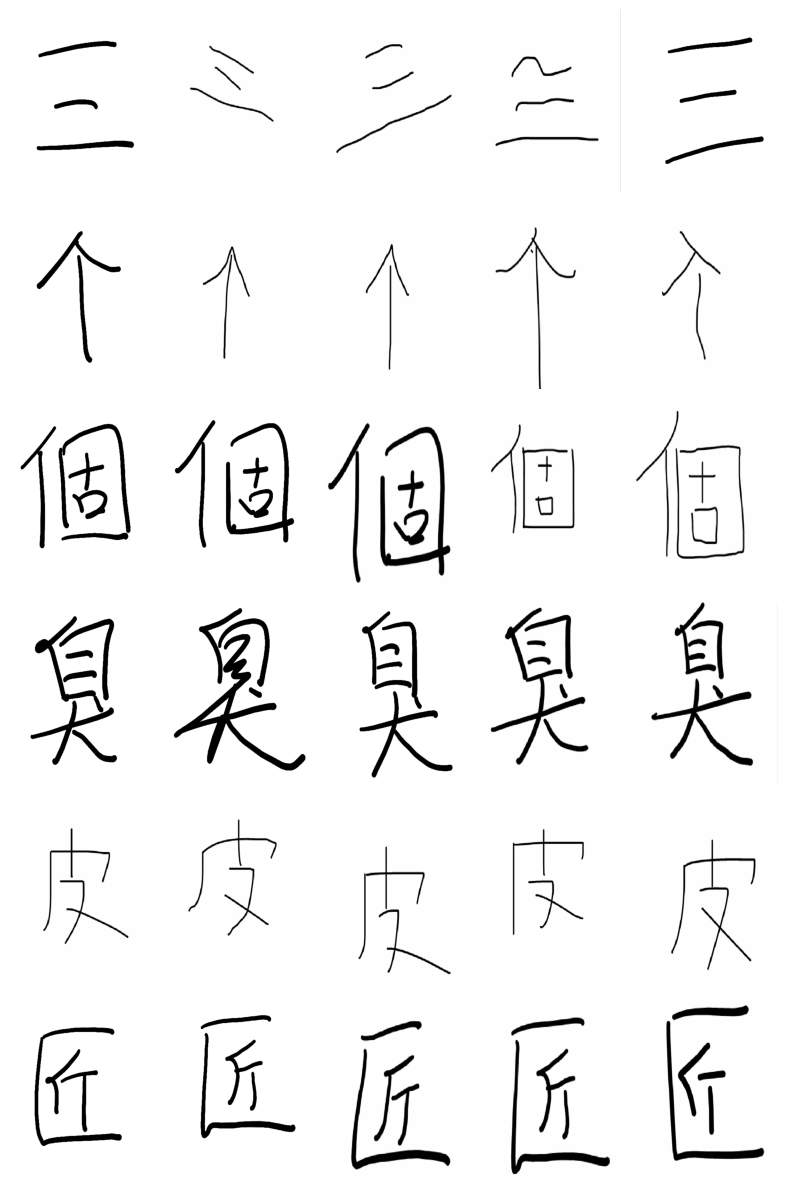

In [20]:
# Plot the images

# Calculate the number of rows based on the number of images
def create_chart(image_arrays_rgb, predicted_labels=None):
    num_images = len(image_arrays_rgb)
    num_rows = (num_images + 3) // 5  # Round up to the nearest integer

    # Create the subplot grid
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(8, 2*num_rows))

    # Iterate over the images
    for i, image in enumerate(image_arrays_rgb):
        row_idx = i // 5
        col_idx = i % 5
        ax = axes[row_idx, col_idx]
        ax.imshow(image, cmap="gray_r")
        ax.axis('off')

        # Add the predicted label as text
        if predicted_labels is not None:
            predicted_label = predicted_labels[i]
            ax.text(0.5, -0.15, f"Predicted: {predicted_label}", transform=ax.transAxes, ha='center')

    # Remove empty subplots
    if num_images % 5 != 0:
        for i in range(num_images, num_rows*5):
            row_idx = i // 5
            col_idx = i % 5
            fig.delaxes(axes[row_idx, col_idx])

    plt.tight_layout()
    plt.show()

create_chart(image_arrays_rgb)

#### 3.2 Train a basic gradient boosting model

In the first section, a basic gradient boosting model is created with the most optimum parameters (n_estimators reduced from 100 to 20) from Question 2. This is to reduce computational time of performing Grid Search again. Its performance will then be measured against the "unseen" data to determine if additional steps such as feature selection is needed.

In [21]:
# Reshape the image arrays

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_reshaped.shape

(309, 205600)

As the training time can take an upwards of 5 minutes, the pre-trained model has already been dumped via joblib and will be called again.

For reference:
```python
# Build the model
gbc_classifier_base = GradientBoostingClassifier(learning_rate=0.1, max_depth=2, n_estimators=20, random_state=42)

# Fit the model
gbc_classifier_base.fit(X_train_reshaped, y_train)

# Dump the file
dump(gbc_classifier_base, 'gbc_classifier_base.joblib')
```

In [22]:
# Load the model
gbc_classifier_base = load('gbc_classifier_base.joblib')

# Accuracy score
y_train_pred = gbc_classifier_base.predict(X_train_reshaped)
accuracy = accuracy_score(y_train, y_train_pred)
print("Base Model training accuracy:", round(accuracy,4))

Base Model training accuracy: 0.9773


#### 3.2.1 Build a dataframe to gauge performance

In [23]:
# Create custom function
def create_probability_array(image_array, gbc_classifier, selector=None):
    df_probabilities = pd.DataFrame()
    
    for image in image_array:
        # Reshape the image
        image = np.reshape(image, (1, -1))

        # Transform the image if a selector is provided
        if selector is not None:
            image = selector.transform(image)
        else:
            image = image

        # Predict probabilities & predicted_labels for each class
        probabilities = np.round(gbc_classifier.predict_proba(image),4)
        predicted_labels = gbc_classifier.predict(image)
        
        # Create a DataFrame for the image
        df_image = pd.DataFrame({"predicted_label": predicted_labels})

        # Add probabilities for each class to the DataFrame
        df_image = pd.concat([df_image, pd.DataFrame(probabilities, columns=gbc_classifier.classes_)], axis=1)

        # Append to the main DataFrame
        df_probabilities = df_probabilities.append(df_image, ignore_index=True)
        
    generate_class_percentages(df_probabilities)
    create_chart(image_arrays_rgb, df_probabilities["predicted_label"])    
    # render the DataFrame as HTML
    return df_probabilities

    # calculate the % of each class
def generate_class_percentages(df_probabilities):
    count_1_san = df_probabilities["predicted_label"].iloc[0:5].eq('1-San').sum()/5 *100
    count_2_ge = df_probabilities["predicted_label"].iloc[5:10].eq('2-Ge').sum()/5 *100
    count_2_gefanti = df_probabilities["predicted_label"].iloc[10:15].eq('2-Ge_fanti').sum()/5 *100
    count_3_chou = df_probabilities["predicted_label"].iloc[15:20].eq('3-Chou').sum()/5 *100
    count_4_pi = df_probabilities["predicted_label"].iloc[20:25].eq('4-Pi').sum()/5 *100
    count_5_jiang = df_probabilities["predicted_label"].iloc[25:30].eq('5-Jiang').sum()/5 *100

    print("Summary:")
    print("1-San: {:.2f}%".format(count_1_san))
    print("2-Ge: {:.2f}%".format(count_2_ge))
    print("2-Ge_fanti: {:.2f}%".format(count_2_gefanti))
    print("3-Chou: {:.2f}%".format(count_3_chou))
    print("4-Pi: {:.2f}%".format(count_4_pi))
    print("5-Jiang: {:.2f}%".format(count_5_jiang))
    print("="*30)
    print(f"Average Accuracy: {np.round((count_1_san + count_2_ge + count_2_gefanti + count_3_chou + count_4_pi + count_5_jiang)/6, 2)}%")
    print(f"Hit Rate: {(count_1_san + count_2_ge + count_2_gefanti + count_3_chou + count_4_pi + count_5_jiang)/20} / 30")
    print("="*30)
    print("Detailed Report:")


Summary:
1-San: 60.00%
2-Ge: 100.00%
2-Ge_fanti: 20.00%
3-Chou: 60.00%
4-Pi: 40.00%
5-Jiang: 80.00%
Average Accuracy: 60.0%
Hit Rate: 18.0 / 30
Detailed Report:


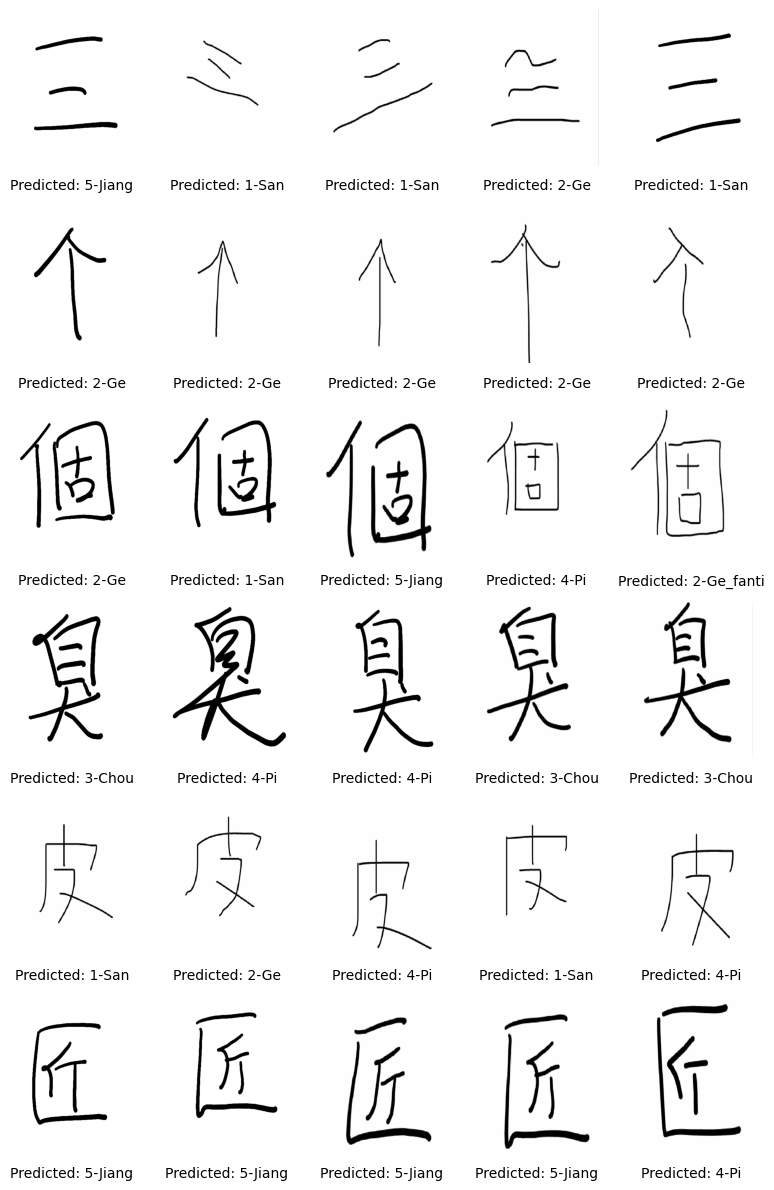

,predicted_label,1-San,2-Ge,2-Ge_fanti,3-Chou,4-Pi,5-Jiang
0,5-Jiang,0.1716,0.0794,0.0132,0.0608,0.0551,0.6199
1,1-San,0.2819,0.2267,0.0225,0.1769,0.1422,0.1498
2,1-San,0.3094,0.2037,0.0247,0.1560,0.1414,0.1648
3,2-Ge,0.2267,0.2992,0.0234,0.1231,0.1495,0.1781
4,1-San,0.7843,0.0644,0.0078,0.0467,0.0447,0.0521
5,2-Ge,0.0442,0.8412,0.0048,0.0265,0.0514,0.0318
6,2-Ge,0.1541,0.5153,0.0157,0.0828,0.0900,0.1420
7,2-Ge,0.1659,0.4251,0.0212,0.1258,0.1210,0.1411
8,2-Ge,0.1635,0.5530,0.0146,0.0884,0.0833,0.0971
9,2-Ge,0.1662,0.4185,0.0188,0.1633,0.1076,0.1255


In [24]:
# Call the function
create_probability_array(image_arrays, gbc_classifier_base)

#### 3.2.1 Observations

It was observed that the base GradientBoosting model, even with the tuned parameters was barely able to get above the 60% mark. However, the main issue identified was the probabilities calculated were not "concrete"; i.e. it ranges between 0.3 - 0.5 probability of it being the correct word. This suggests that the model is not as confident as expected.

In the next section, the 2 feature selection methods will be used to improve the performance, namely select k-best and PCA.

#### 3.3 Feature Selection & Dimensionality Reduction - **Select K Best**

During the testing using the base model, it was observed that the training of 309 images in its original dimension was computationally expensive and took a long time to train. Thus in this section, the select K best method was used to determine the optimal number of features. 

As the total features was 205_600 which were mostly made up of whitespace, the statistical relationship between each feature and the target variable must be evaluated in order to select the top K features with the highest scores. By doing so, the machine chooses the most informative features for the given task while reducing the dimensionality of the data. <br>

A few trial and errors (100 to 100_000 features) were used to determine the optimum number of k features, and finally 30_000 features was chosen.

```python
# Build the model
gbc_classifier_selectk = GradientBoostingClassifier(learning_rate=0.1, max_depth=2, n_estimators=20, random_state=42)
gbc_classifier_selectk.fit(X_train_selectk, y_train)

# dump the model
dump(gbc_classifier_selectk, 'gbc_classifier_selectk.joblib')
```

In [25]:
# select k best features
from sklearn.feature_selection import SelectKBest, f_classif

# Create and fit selector
select_kbest = SelectKBest(score_func=f_classif, k=100_000)
X_train_selectk = select_kbest.fit_transform(X_train_reshaped, y_train)

# load the model
gbc_classifier_selectk = load('gbc_classifier_selectk.joblib')

# Accuracy score
y_train_pred = gbc_classifier_selectk.predict(X_train_selectk)
accuracy = accuracy_score(y_train, y_train_pred)
print("Base Model + Select K Best Training accuracy:", round(accuracy,4))

Base Model + Select K Best Training accuracy: 0.9579


Summary:
1-San: 80.00%
2-Ge: 100.00%
2-Ge_fanti: 20.00%
3-Chou: 80.00%
4-Pi: 40.00%
5-Jiang: 60.00%
Average Accuracy: 63.33%
Hit Rate: 19.0 / 30
Detailed Report:


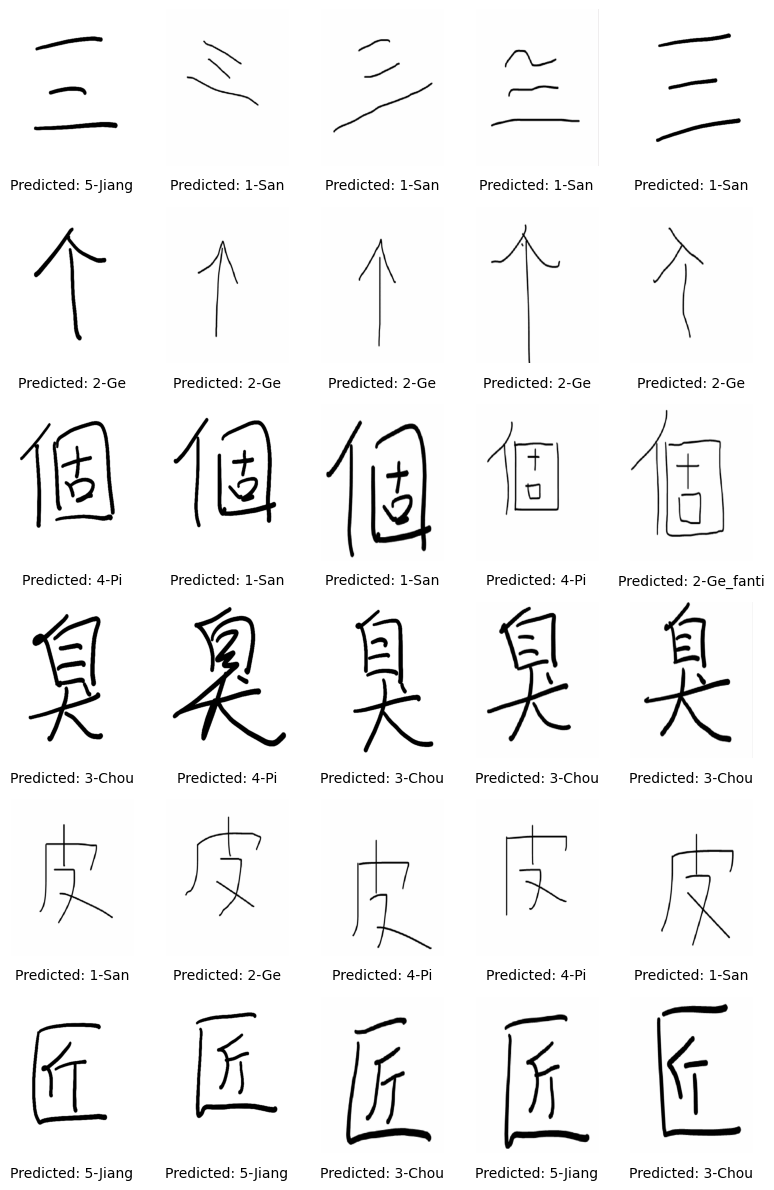

,predicted_label,1-San,2-Ge,2-Ge_fanti,3-Chou,4-Pi,5-Jiang
0,5-Jiang,0.2337,0.0912,0.0173,0.0762,0.0677,0.5139
1,1-San,0.2974,0.2303,0.0318,0.1329,0.1429,0.1648
2,1-San,0.2985,0.1932,0.0319,0.1614,0.1497,0.1654
3,1-San,0.2404,0.2200,0.0363,0.1518,0.1632,0.1883
4,1-San,0.6533,0.0967,0.0160,0.0796,0.0717,0.0827
5,2-Ge,0.0438,0.8195,0.0058,0.0368,0.0608,0.0332
6,2-Ge,0.2118,0.3445,0.0284,0.1398,0.1279,0.1475
7,2-Ge,0.2068,0.2774,0.0347,0.1451,0.1560,0.1800
8,2-Ge,0.2097,0.4158,0.0252,0.1054,0.1133,0.1307
9,2-Ge,0.1936,0.3333,0.0288,0.1656,0.1294,0.1493


In [26]:
# Generate the report
create_probability_array(image_arrays, gbc_classifier_selectk, select_kbest)

#### 3.3 Feature Selection & Dimensionality Reduction - **PCA**

After K-best was used, a slight improvement to both accuracy and training time was observed, however there is definitely still room for improvement.

| Model |Training Time | Average Accuracy (Test Data) | Hits (of 30) |
| ----------- | ----------- | ----------- | ----------- |
| Base | ~5 - 6m | 60.00% | 18 |
| Base + Select K Best | ~1.30 - 2m | 63.33% | 19
| Base + PCA | <i>Discussed below</i> | <i>Discussed below</i> | <i>Discussed below</i>  |

In the last section, PCA was applied to identify the principal components that capture the most significant variations in the data. It is used to improve performance by reducing dimensionality and capturing the most important characteristics of the data.<br>

A few trial and errors (1, 2, 3, 5, 15, 30, 45 components and etc..) were used to determine the optimum number of PCA components, and finally 0.95 variance features were chosen.

Note that no dumping of the gbc_classifier file was required due to the extremely fast model training time.

In [27]:
# PCA
from sklearn.decomposition import PCA

# Create and fit PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_reshaped, y_train)

# Train the PCA model
gbc_classifier_pca = GradientBoostingClassifier(learning_rate=0.1, max_depth=2, n_estimators=300, random_state=42)
gbc_classifier_pca.fit(X_train_pca, y_train)

# Accuracy score
y_train_pred = gbc_classifier_pca.predict(X_train_pca)
accuracy = accuracy_score(y_train, y_train_pred)
print("Base Model + PCA Training accuracy:", round(accuracy,4))

Base Model + PCA Training accuracy: 1.0


Summary:
1-San: 60.00%
2-Ge: 100.00%
2-Ge_fanti: 40.00%
3-Chou: 80.00%
4-Pi: 80.00%
5-Jiang: 60.00%
Average Accuracy: 70.0%
Hit Rate: 21.0 / 30
Detailed Report:


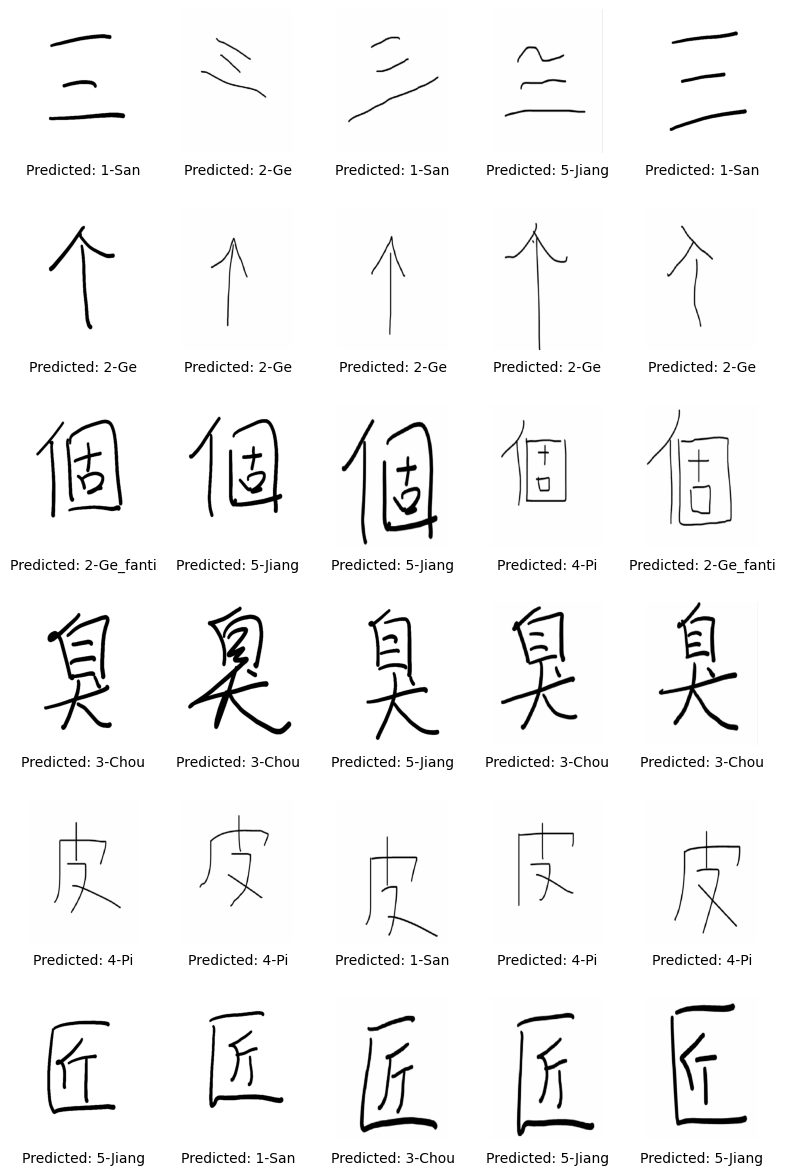

,predicted_label,1-San,2-Ge,2-Ge_fanti,3-Chou,4-Pi,5-Jiang
0,1-San,0.9963,0.0003,0.0016,0.0002,0.0006,0.0011
1,2-Ge,0.0376,0.9586,0.0001,0.0008,0.0020,0.0009
2,1-San,0.4244,0.4216,0.0000,0.1073,0.0424,0.0043
3,5-Jiang,0.2458,0.0317,0.0063,0.1680,0.1615,0.3867
4,1-San,0.9992,0.0002,0.0003,0.0000,0.0002,0.0001
5,2-Ge,0.0000,0.9929,0.0001,0.0008,0.0044,0.0019
6,2-Ge,0.0031,0.9941,0.0000,0.0008,0.0018,0.0002
7,2-Ge,0.0047,0.9929,0.0000,0.0001,0.0022,0.0001
8,2-Ge,0.0001,0.9904,0.0000,0.0012,0.0075,0.0008
9,2-Ge,0.0001,0.9948,0.0000,0.0026,0.0021,0.0003


In [28]:
# Generate the report
create_probability_array(image_arrays, gbc_classifier_pca, pca)

#### 3.4 Conclusion

After comparing all 3 variations of the Gradient Boosting Classifier, conclusion can be drawn that the base model has benefited immensely from using dimensionality reduction techniques. 

For example, the model improved a total of +10.00% in accuracy while reducing the computational time significantly (~99%). There were also improvements observed in the probabilities (previously 0.3 - 0.5) to a more concrete ~0.5 to 0.8 of the words that the model predicted correctly.

| Model |Training Time | Average Accuracy (Test Data) | Hits (of 30) |
| ----------- | ----------- | ----------- | ----------- |
| Base | ~5 - 6m | 60.00% | 18 |
| Base + Select K Best | ~1.30 - 2m | 63.33% | 19
| Base (300 estimators) + PCA | ~15 - 20s | 70.00% | 21 |

Overall, based on the training above, it was observed that despite using dimensionality reduction techniques to improve the model, the model still suffered from a lack of training data. To further strengthen the model in the foreesable future, more training data could be added to make better predictions.